In [23]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,porter
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import string
import pandas
import numpy as np
import re

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read data
def maxCase(x):
    result = [i for (i,v) in zip(range(-2,3),[y==max(x) for y in x]) if v]
    if(len(result) > 1):
        s = sum(result)
        if(s < -2):
            return -2
        elif(s > 2):
            return 2
        else:
            return s
    else:
        return result[0]
    
def worstCase(x):
    if x['vneg']>0:
        return -2
    elif x['neg']>0:
        return -1
    elif x['neutral']>0:
        return 0
    elif x['pos']>0:
        return 1
    else:
        return 2
    
def bestCase(x):
    if x['vpos']>0:
        return 2
    elif x['pos']>0:
        return 1
    elif x['neutral']>0:
        return 0
    elif x['neg']>0:
        return -1
    else:
        return -2
    
def twoClass(x):
    if x<0:
        return -1
    else:
        return 1

reviews = pandas.read_pickle('consumer_affairs_sallie_mae.data')
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'acct','account',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'referenceevery','reference every',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'thats','that\'s',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'interesrt','interest',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'don\'t','do not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'wouldn\'t','would not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'couldn\'t','could not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'shouldn\'t','should not',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'forebearance','forbearance',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'fultime','full time',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'harrass','harass',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'harrassing','harassing',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'inschool','in school',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'mei','me',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'parttime','part time',x,flags=re.IGNORECASE))
reviews['review'] = reviews['review'].apply(lambda x: re.sub(r'recieved','received',x,flags=re.IGNORECASE))


sentiments = pandas.read_csv('review_sentiment_coreNLP.txt')
sentiments_R = pandas.read_csv('Score_of_reviews.csv')['scores']
reviews['sentiment'] = sentiments.apply(bestCase,axis=1).apply(twoClass)

## Define pre-processing functions for text

In [3]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(",".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def top_words(model,feature_names,n_top_words):
    topics = []
    terms = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append(topic_idx)
        terms.append(','.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    return pandas.DataFrame({'topic':topics,'terms':terms},columns=['topic','terms'])    

def noPunct(txt):
    punct_list = string.punctuation + '’' + '”' + '“'
    for punct in punct_list:
        txt = txt.replace(punct,'')
    return txt

def noNumber(txt):
    return re.sub(r'[$\s]*\d+\.?\d*','',txt)

def addNegation(x):
    pattern = r'not (.+)[' + string.punctuation + r']'
    q = re.search(pattern,x,flags=re.IGNORECASE)
    if q is None:
        return x
    replacement = ['not_' + i for i in q.group(1).split(' ')]
    replacement = ' '.join(replacement)
    return x.replace(q.group(),replacement)

def LemmaTokenizer(doc):
    #doc = addNegation(doc)
    wnl = WordNetLemmatizer()
    lemmas =[wnl.lemmatize(t) for t in word_tokenize(doc)]
    lemmas = [noPunct(l) for l in lemmas]
    lemmas = [noNumber(l) for l in lemmas]
    lemmas = list(filter(lambda x: len(x) > 0,lemmas))
    return lemmas

def StemmerTokenizer(doc):
    #doc = addNegation(doc)
    port = porter.PorterStemmer()
    tokens =[port.stem(t) for t in word_tokenize(doc)]
    tokens = [noPunct(t) for t in tokens]
    tokens = [noNumber(l) for l in tokens]
    tokens = list(filter(lambda x: len(x) > 0,tokens))
    return tokens

extra_stopwords = stopwords.words('english') + ['company','would','get','school','student','sally','salliemae','im','sallie','mae','loan','nt','wo','wa','tg','va','ca','mo','le','ha','sm','itt','k','smae']
extra_stopwords = extra_stopwords + ['not_' + x for x in extra_stopwords]

## Create a term frequency - inverse document frequency matrix

In [4]:
tfidf_maker = TfidfVectorizer(lowercase=True, analyzer='word', stop_words=extra_stopwords,tokenizer=LemmaTokenizer,
                        ngram_range=(1,1), binary=False, norm='l1', use_idf=True, smooth_idf=True, sublinear_tf=True,
                       max_features=None,min_df=10,max_df=0.8)
tfidf = tfidf_maker.fit_transform(reviews['review'])
feature_names = tfidf_maker.get_feature_names()

In [5]:
pandas.DataFrame(tfidf.todense(),columns=feature_names).head()

,ability,able,absolutely,abusive,accept,accepted,accepting,access,according,account,...,wrote,x,yeah,year,yes,yesterday,yet,young,yr,zero
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016249,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010423,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005578,...,0.0,0.0,0.0,0.004259,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.006193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009459,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.006793,0.0,0.0,0.0


## Create a term frequency matrix

In [6]:
tf_maker = CountVectorizer(lowercase=True,analyzer ='word',tokenizer=LemmaTokenizer,max_features=None,
                 stop_words=extra_stopwords,ngram_range=(1,1),min_df=10,max_df=0.8)
tf = tf_maker.fit_transform(reviews['review'])
tf_feature_names = tf_maker.get_feature_names()

In [7]:
pandas.DataFrame(tf.todense(),columns=tf_feature_names).head()

,ability,able,absolutely,abusive,accept,accepted,accepting,access,according,account,...,wrote,x,yeah,year,yes,yesterday,yet,young,yr,zero
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,2,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,1,0,0,0


## Non negative matrix factorization

In [8]:
nmf = NMF(n_components=5,l1_ratio=0,alpha=0,random_state=20170206).fit(tfidf)
nmf_transform = nmf.transform(tfidf)

In [18]:
display(pandas.DataFrame(nmf_transform).head())
display(pandas.DataFrame(nmf_transform.dot(nmf.components_),columns=feature_names).head())

,0,1,2,3,4
0,0.026336,0.000000,0.023038,0.000000,0.000000
1,0.016210,0.000000,0.039572,0.002071,0.002918
2,0.005661,0.000000,0.050138,0.012099,0.002872
3,0.028274,0.012066,0.003572,0.005518,0.002724
4,0.021234,0.007386,0.024538,0.000000,0.001405


,ability,able,absolutely,abusive,accept,accepted,accepting,access,according,account,...,wrote,x,yeah,year,yes,yesterday,yet,young,yr,zero
0,0.000201,0.001463,0.001052,0.000177,0.000499,0.000258,0.000142,0.000603,0.000359,0.006334,...,0.000227,0.000442,0.000150,0.000299,0.000560,0.000469,0.001986,0.000467,0.000201,8.286104e-07
1,0.000274,0.000955,0.001807,0.000121,0.000491,0.000243,0.000186,0.001035,0.000493,0.010085,...,0.000296,0.000543,0.000136,0.000343,0.000419,0.000329,0.001805,0.000297,0.000126,4.816811e-05
2,0.000333,0.000533,0.002289,0.000059,0.000454,0.000231,0.000214,0.001312,0.000561,0.012506,...,0.000371,0.000577,0.000108,0.000996,0.000252,0.000172,0.001467,0.000158,0.000046,2.324632e-04
3,0.000179,0.002038,0.000163,0.000188,0.000438,0.000231,0.000077,0.000093,0.000304,0.001763,...,0.000170,0.000385,0.000147,0.004378,0.000593,0.000471,0.001726,0.000549,0.000367,2.068624e-04
4,0.000239,0.001409,0.001120,0.000147,0.000468,0.000226,0.000137,0.000642,0.000442,0.006552,...,0.000229,0.000504,0.000144,0.002464,0.000501,0.000388,0.001784,0.000389,0.000254,6.465350e-05


In [19]:
reg_nmf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
reg_nmf.fit(nmf_transform,reviews['sentiment'])
coef_nmf = pandas.DataFrame(np.transpose(reg_nmf.coef_),columns=[reviews['sentiment'][0]])
dominance = np.apply_along_axis(lambda x: [y for (y,z) in zip(range(len(x)),x) if z==max(x)][0],1,nmf_transform)
dominance = pandas.Series(dominance)
dominance = dominance.value_counts()/len(dominance)
if reviews['sentiment'][0] == -1:
    response_label = 'Score for Negativity'
else:
    response_label = 'Score for Positivity'
nmf_output = pandas.concat([coef_nmf,dominance,top_words(nmf,feature_names,20)],axis=1)
nmf_output.columns = [response_label,'Percent Dominance','Topic','Terms']
nmf_output.to_excel('non neg matrix factorization topics.xlsx',index=False)
nmf_output

,Score for Negativity,Percent Dominance,Topic,Terms
0,0.346227,0.503053,0,"call,phone,time,told,day,number,calling,called..."
1,-0.260581,0.188550,1,"interest,year,pay,high,amount,principal,paying..."
2,-0.610431,0.235115,2,"payment,late,fee,account,check,bank,month,sent..."
3,-0.183454,0.060305,3,"report,credit,replied,listed,however,asked,rep..."
4,-0.461686,0.012977,4,"present,refuse,already,bill,paid,original,bala..."


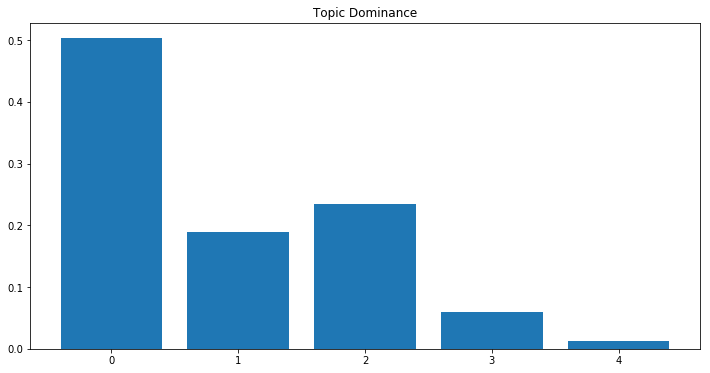

In [38]:
plt.figure(figsize=(12,6))
plt.bar(range(len(nmf_output)),nmf_output['Percent Dominance'])
plt.title('Topic Dominance')
plt.show()

In [21]:
for i in range(len(nmf.components_)):
    r = pandas.concat([pandas.DataFrame(nmf_transform),reviews[['review','sentiment']]],axis=1).sort_values(i,ascending=False).reset_index()
    rank = 10
    print('Topic {} {:1.4f}'.format(i,r.loc[rank,i]))
    print(r.loc[rank,'review'] + '\n')

Topic 0 0.0575
Apparently, this Jacylyn ** that they keep harassing me about is not paying her loan and must have given them a wrong number such as mine. They call me all the time even 8:00 am on Saturdays and 8:00 pm on Sunday. They won't stop. The people they have working there are incompetent and I do not know what to do to stop these harassing calls for someone else.

Topic 1 0.0971
My student loan interest is now 13%.  Which is crazy due to the current interest rate.  I got this loan on line and had no idea it was that high.  When trying to reduce it or have a co-signer I am told the only thing I can do is pay it off.  How can a student loan have that high of interest rate? Does anyone know how I can get this rate lowered.  Is there not a cap on interest rates for students.  I just finished four years at Columbia College Chicago. I do not want this to happen to another student.  13% is almost criminal!!!

Topic 2 0.0807
Over the course of the past year, Sallie Mae has: (1) applied

## Topic Modeling with Latent Dirichlet Allocation

You can use a function of the log likelihood (perplexity) to start an initial search for the number of latent topics. Most times the "best" number from the graph will not make sense practically though.

perpelxity = exp(-log likelihood / count of tokens)

Finished 2 of 20
Finished 3 of 20
Finished 4 of 20
Finished 5 of 20
Finished 6 of 20
Finished 7 of 20
Finished 8 of 20
Finished 9 of 20
Finished 10 of 20
Finished 11 of 20
Finished 12 of 20
Finished 13 of 20
Finished 14 of 20
Finished 15 of 20
Finished 16 of 20
Finished 17 of 20
Finished 18 of 20
Finished 19 of 20
Finished 20 of 20


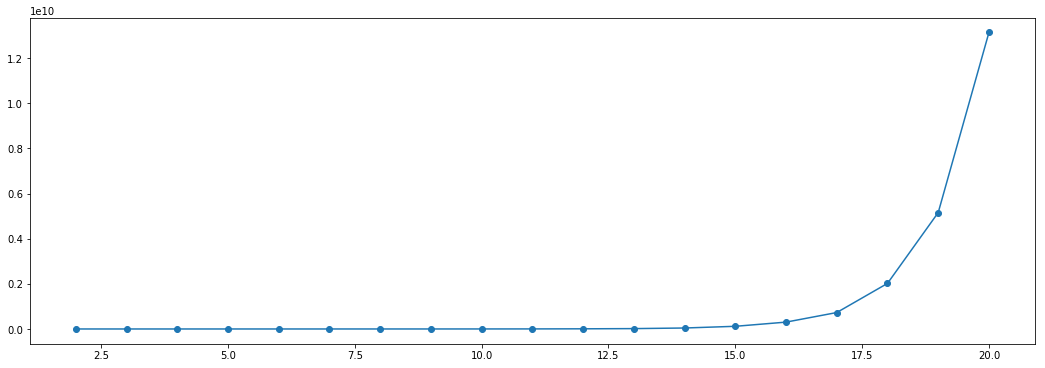

In [29]:
n_topic = range(2,21)
perplexities = []
for n in n_topic:
    lda = LatentDirichletAllocation(n_topics=n,max_iter=10,learning_method='batch',
                                    evaluate_every=0,n_jobs=7,random_state=20170206)
    lda.fit(tf)
    perplexities.append(lda.perplexity(tf))
    print('Finished %d of %d' % (n,max(n_topic)))

plt.figure(figsize=(18,6))    
plt.plot(n_topic,perplexities,'-o')
plt.show()

In [34]:
lda = LatentDirichletAllocation(n_topics=6,max_iter=500,learning_method='batch',
                                evaluate_every=0,n_jobs=8,random_state=20170206)
lda.fit(tf)
lda_transform = lda.transform(tf)

In [35]:
reg_lda = LogisticRegression(multi_class='multinomial',solver='newton-cg')
reg_lda.fit(lda_transform,reviews['sentiment'])
coef_lda = pandas.DataFrame(np.transpose(reg_lda.coef_),columns=[reviews['sentiment'][0]])
dominance = np.apply_along_axis(lambda x: [y for (y,z) in zip(range(len(x)),x) if z==max(x)][0],1,lda_transform)
dominance = pandas.Series(dominance)
dominance = dominance.value_counts()/len(dominance)
lda_output = pandas.concat([coef_lda,dominance,top_words(lda,tf_feature_names,20)],axis=1)
if reviews['sentiment'][0] == -1:
    response_label = 'Score for Negativity'
else:
    response_label = 'Score for Positivity'
lda_output.columns = [response_label,'Percent Dominance','Topic','Terms']
lda_output.to_excel('latent dirichlet allocation topics.xlsx',index=False)
lda_output

,Score for Negativity,Percent Dominance,Topic,Terms
0,-0.082739,0.096183,0,"payment,late,month,account,fee,pay,time,due,ba..."
1,0.144126,0.343511,1,"pay,month,job,year,money,payment,time,work,mak..."
2,-0.013369,0.119847,2,"payment,interest,pay,amount,rate,month,year,pa..."
3,-0.300497,0.052672,3,"forbearance,told,received,deferment,form,lette..."
4,-0.224395,0.169466,4,"account,payment,customer,credit,service,check,..."
5,0.476874,0.218321,5,"call,phone,day,told,time,said,called,number,ca..."


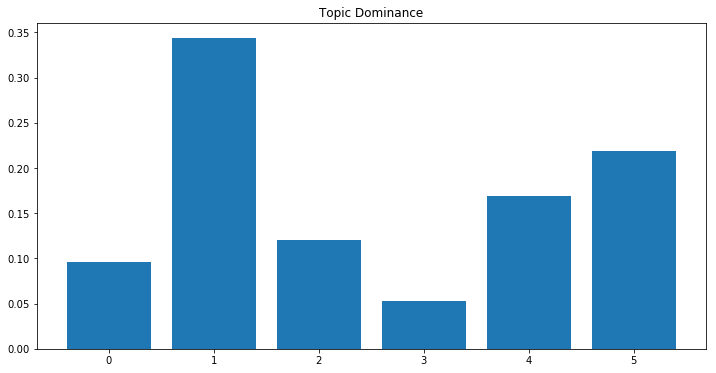

In [39]:
plt.figure(figsize=(12,6))
plt.bar(range(len(lda_output)),lda_output['Percent Dominance'],tick_label=range(len(lda_output)))
plt.title('Topic Dominance')
plt.show()

In [37]:
for i in range(len(lda.components_)):
    r = pandas.concat([pandas.DataFrame(lda_transform),reviews[['review','sentiment']]],axis=1).sort_values(i,ascending=False).reset_index()
    rank = 0
    print('Topic {} {:4.2f}%'.format(i,100*r.loc[rank,i]))
    print(r.loc[rank,'review'] + '\n')

Topic 0 98.47%
I have lived in the UK for 10 years. Sallie Mae makes it next to impossible to pay your loans if you live abroad but do not have an American bank account. You can make card payments over the phone for a $14.00 fee and a $50 phone bill once they figure out how to get your postcode into the system. This happens every time I've paid, for 10 years! That means I've paid $7680 in fees just to make a payment over the years. I've complained countless times but the company NEVER has had the courtesy to respond. Surely a company as big as Sallie Mae can figure out how to create the ability to make online card payments. Every other company in the world does this. Or is being in the dark ages a really convenient way to make tons of money off internationals? Sallie Mae should be ashamed of itself. Me and thousands of others think so!

Topic 1 98.71%
I took loans out with Sallie Mae to go to college.  The school I attended, Katherine Gibbs, was a terrible experience and they did not h